In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/huggingface

/content/drive/MyDrive/huggingface


# Sentence Similarity

## 0. Library 설치

In [3]:
!pip install transformers==4.41.2 evaluate==0.4.0 datasets==2.20.0 scikit-learn==1.4.2 peft==0.10.0
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: token

## 1. Code

### 1) 데이터셋 로드

In [4]:
from datasets import load_dataset, DatasetDict
import pandas as pd

dataset = load_dataset('klue', 'sts')
print(dataset)
print(f"샘플: {dataset['train'][0]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})
샘플: {'guid': 'klue-sts-v1_train_00000', 'source': 'airbnb-rtt', 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.', 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.', 'labels': {'label': 3.7, 'real-label': 3.714285714285714, 'binary-label': 1}}


### 2) EDA

Map:   0%|          | 0/11668 [00:00<?, ? examples/s]

Map:   0%|          | 0/519 [00:00<?, ? examples/s]

{'guid': 'klue-sts-v1_train_00000', 'source': 'airbnb-rtt', 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.', 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.', 'labels': 3.714285714285714}
train 데이터셋의 sentence1: 0
train 데이터셋의 sentence2: 0
train 데이터셋의 label: 0
validation 데이터셋의 sentence1: 0
validation 데이터셋의 sentence2: 0
validation 데이터셋의 label: 0


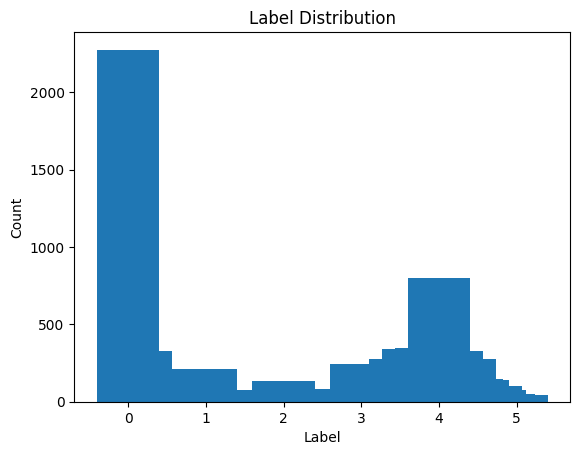

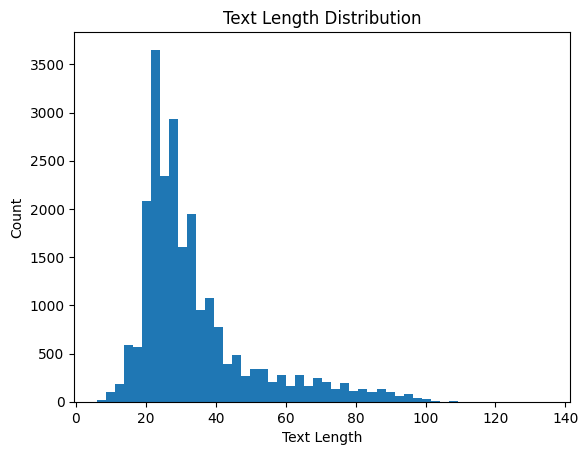

최대 길이: 135
평균 길이: 33.971074734316076
최소 길이: 6


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

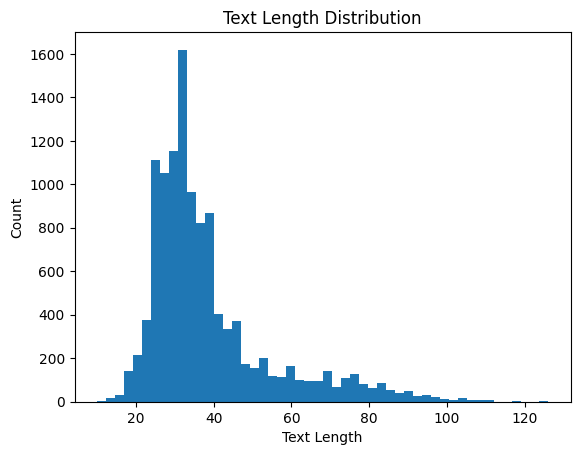

최대 길이: 126
평균 길이: 38.63275625642784
최소 길이: 10


In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 2.1 텍스트, 레이블 컬럼 지정 및 레이블 리스트, id2label, label2id -> regression task이기 때문에 지정하지 않음
TEXT_COL1, TEXT_COL2= 'sentence1', 'sentence2'

def extract_label(examples):
    examples['labels'] = float(examples['labels']['real-label'])
    return examples
dataset = dataset.map(extract_label)
print(dataset['train'][0])
LABEL_COL = 'labels'

# 2.2 텍스트, 레이블 결측치 확인
for split in dataset:
    df = pd.DataFrame(dataset[split])
    missing_1 = df[TEXT_COL1].isna().sum() + (df[TEXT_COL1].astype(str).str.strip() == '').sum()
    missing_2 = df[TEXT_COL2].isna().sum() + (df[TEXT_COL2].astype(str).str.strip() == '').sum()
    missing_label = df[LABEL_COL].isna().sum()
    print(f"{split} 데이터셋의 sentence1: {missing_1}")
    print(f"{split} 데이터셋의 sentence2: {missing_2}")
    print(f"{split} 데이터셋의 label: {missing_label}")

# 2.3 레이블 분포
train_labels = dataset['train'][LABEL_COL]
label_counts = np.unique(train_labels, return_counts=True)
plt.bar(label_counts[0], label_counts[1])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

# 2.4 문자 길이 분포
text_lengths = [len(x) for x in dataset['train'][TEXT_COL1] + dataset['train'][TEXT_COL2]]
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.show()

print(f"최대 길이: {max(text_lengths)}")
print(f"평균 길이: {np.mean(text_lengths)}")
print(f"최소 길이: {min(text_lengths)}")

# 2.5 토큰화가 된 후의 문자 길이 분포
from transformers import AutoTokenizer
MODEL_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
lengths = [len(tokenizer.encode(x[TEXT_COL1], text_pair=x[TEXT_COL2])) for x in dataset['train']]
plt.hist(lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.show()

print(f"최대 길이: {max(lengths)}")
print(f"평균 길이: {np.mean(lengths)}")
print(f"최소 길이: {min(lengths)}")

### 3) Preprocessing

In [6]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# 3.1 결측치 처리: text NaN/빈 문장 제거
def not_empty(ex, text_cols=[TEXT_COL1, TEXT_COL2]):
    for col in text_cols:
        s = ex.get(col, None)
        if s is None:
            return False
        if len(str(s).strip()) == 0:
            return False

    return True

dataset = dataset.filter(not_empty)
print(dataset)

# 3.2 토크나이저 및 collator 정의
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"tokenizer: {tokenizer}")
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3.3 데이터 분할
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['test'],
    'test': dataset['validation']
})
print(f"분할 후 데이터셋: {dataset}")

# 3.4 토크나이저 함수 정의
MAX_LEN = 128
def tokenize_func(examples):
    return tokenizer(examples[TEXT_COL1], text_pair=examples[TEXT_COL2], truncation=True, max_length=MAX_LEN)

tokenized = dataset.map(tokenize_func, batched=True, remove_columns=['guid', 'source', 'sentence1', 'sentence2'])
print(f"tokenized dataset: {tokenized}")

Filter:   0%|          | 0/11668 [00:00<?, ? examples/s]

Filter:   0%|          | 0/519 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})
tokenizer: BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=Fa

Map:   0%|          | 0/9334 [00:00<?, ? examples/s]

Map:   0%|          | 0/2334 [00:00<?, ? examples/s]

Map:   0%|          | 0/519 [00:00<?, ? examples/s]

tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9334
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2334
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 519
    })
})


### 4) 모델 및 학습 설정

In [7]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1, problem_type='regression')
print(f"Model: {model}")

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print(f"No GPU available, using the CPU instead.")
model.to(device)


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 5) 데이터 로더 설정

In [8]:
print(f"학습 데이터: {tokenized['train']}")
print(f"검증 데이터: {tokenized['validation']}")
print(f"테스트 데이터: {tokenized['test']}")

학습 데이터: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9334
})
검증 데이터: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2334
})
테스트 데이터: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 519
})


In [9]:
from torch.utils.data import DataLoader

def _to_dataloader(dataset, collator, batch_size, shuffle=False):
    return DataLoader(
        dataset,
        collate_fn=collator,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True
    )

train_loader = _to_dataloader(tokenized['train'], collator, batch_size=64, shuffle=True)
val_loader = _to_dataloader(tokenized['validation'], collator, batch_size=64, shuffle=False)
test_loader = _to_dataloader(tokenized['test'], collator, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

146
37
17


In [10]:
print(9334/64, 2334/64, 519/32)

145.84375 36.46875 16.21875


### 6) 학습

In [11]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 5

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

def metrics(preds, labels):
    preds = np.asarray(preds, dtype=np.float64)
    labels = np.asarray(labels, dtype=np.float64)

    # scipy 버전에 따라 반환 타입이 다를 수 있어 안전 처리
    pear = pearsonr(preds, labels)
    pearson = float(getattr(pear, "statistic", pear[0]))
    spear = spearmanr(preds, labels)
    spearman = float(getattr(spear, "correlation", spear[0]))

    mse = float(mean_squared_error(labels, preds))
    mae = float(mean_absolute_error(labels, preds))

    return {
        "pearson": pearson,
        "spearman": spearman,
        "mse": mse,
        "mae": mae,
    }

def train(model, train_loader, optimizer, device, max_grad_norm=1.0):

    total_train_loss = 0.0
    model.train()

    for step, batch in tqdm(enumerate(train_loader), desc="Training Batch"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids = batch['input_ids'],
            attention_mask = batch['attention_mask'],
            labels = batch['labels']
        )
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()

        # 선택: gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total_train_loss += loss.item()

    return total_train_loss / len(train_loader)

def evaluate(model, valid_loader, device):
    model.eval()

    total_eval_loss = 0.0
    preds, labels = [], []

    with torch.no_grad():
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            if outputs.loss is not None:
                total_eval_loss += outputs.loss.item()

            pred = outputs.logits.squeeze(-1).detach().cpu().numpy()
            label = batch['labels'].detach().cpu().numpy()

            preds.append(pred)
            labels.append(label)

    preds = np.concatenate(preds, axis=0)
    labels  = np.concatenate(labels, axis=0)
    eval_metrics = metrics(preds, labels)

    return total_eval_loss / len(valid_loader), eval_metrics

In [13]:
best_mse = float('inf')
best_pearson = -float('inf')
best_ckpt_path = "./klue_bert_sts_model_pytorch.pt"

for epoch in range(epochs):
    print(f"========== Epoch {epoch+1} / {epochs} ==========")

    # 학습
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Epoch{epoch+1} Train Loss: {train_loss:.4f}")

    # 검증 (회귀 지표 출력)
    avg_val_loss, val_metrics = evaluate(model, val_loader, device)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(
        "Pearson: {pear:.4f} | Spearman: {spear:.4f} | "
        "MSE: {mse:.4f} | MAE: {mae:.4f}".format(
            pear=val_metrics["pearson"],
            spear=val_metrics["spearman"],
            mse=val_metrics["mse"],
            mae=val_metrics["mae"],
        )
    )

    # 체크포인트 저장 기준: Pearson 최대화(동률 시 MSE 최소로 보조 판단)
    is_better = (val_metrics["pearson"] > best_pearson) or (
        np.isclose(val_metrics["pearson"], best_pearson) and val_metrics["mse"] < best_mse
    ) if 'best_mse' in globals() else (val_metrics["pearson"] > best_pearson)

    if is_better:
        print(
            f"Validation metric improved. "
            f"Saving model to {best_ckpt_path} ..."
        )
        torch.save(model.state_dict(), best_ckpt_path)
        best_pearson = val_metrics["pearson"]
        best_mse = val_metrics["mse"]

========== Epoch 1 / 5 ==========


Training Batch: 146it [02:07,  1.15it/s]


Epoch1 Train Loss: 0.6117
Validation Loss: 0.2589
Pearson: 0.9676 | Spearman: 0.9319 | MSE: 0.2573 | MAE: 0.3712
Validation metric improved. Saving model to ./klue_bert_sts_model_pytorch.pt ...
========== Epoch 2 / 5 ==========


Training Batch: 146it [02:10,  1.12it/s]


Epoch2 Train Loss: 0.1641
Validation Loss: 0.2004
Pearson: 0.9725 | Spearman: 0.9378 | MSE: 0.2007 | MAE: 0.3164
Validation metric improved. Saving model to ./klue_bert_sts_model_pytorch.pt ...
========== Epoch 3 / 5 ==========


Training Batch: 146it [02:09,  1.13it/s]


Epoch3 Train Loss: 0.1182
Validation Loss: 0.2602
Pearson: 0.9719 | Spearman: 0.9385 | MSE: 0.2594 | MAE: 0.3875
========== Epoch 4 / 5 ==========


Training Batch: 146it [02:09,  1.13it/s]


Epoch4 Train Loss: 0.0981
Validation Loss: 0.1676
Pearson: 0.9732 | Spearman: 0.9378 | MSE: 0.1681 | MAE: 0.2977
Validation metric improved. Saving model to ./klue_bert_sts_model_pytorch.pt ...
========== Epoch 5 / 5 ==========


Training Batch: 146it [02:08,  1.13it/s]


Epoch5 Train Loss: 0.0806
Validation Loss: 0.1948
Pearson: 0.9724 | Spearman: 0.9394 | MSE: 0.1944 | MAE: 0.3230


### 7) 모델 로드 및 평가

In [17]:
model.load_state_dict(torch.load(best_ckpt_path))

avg_test_loss, test_metrics = evaluate(model, test_loader, device)
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

Test Loss: 0.4657
Test Metrics: {'pearson': 0.89338322916013, 'spearman': 0.8897347469073499, 'mse': 0.448254666063379, 'mae': 0.49973611727443046}


### 8) 추론하기

In [18]:
from transformers import pipeline

sts_pipe = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0, function_to_apply=None)

inputs = {
    "text": "천방지축 어리둥절 빙글빙글 돌아가는 내 코드",
    'text_pair': "더티코드 지향합니다."
}

print("\n[DEMO]")
print(sts_pipe(inputs))


[DEMO]
{'label': 'LABEL_0', 'score': 0.6141219735145569}


### 9) Push to Hub

In [16]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# (1) 로컬 저장
save_dir = "./saved/sts_bert_regression"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# (2) Hub로 업로드 (새 repo 만들면서 push)
model.push_to_hub("klue-sts-bert-base-regression", private=False)     # 모델 가중치+config
tokenizer.push_to_hub("klue-sts-bert-base-regression")                 # 토크나이저


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpxztqj8mw/model.safetensors    :   0%|          |  557kB /  442MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SpeakingPotato/klue-sts-bert-base-regression/commit/b4405cf656b51208b452adfc3005de8300882db2', commit_message='Upload tokenizer', commit_description='', oid='b4405cf656b51208b452adfc3005de8300882db2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/SpeakingPotato/klue-sts-bert-base-regression', endpoint='https://huggingface.co', repo_type='model', repo_id='SpeakingPotato/klue-sts-bert-base-regression'), pr_revision=None, pr_num=None)